In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict
from sklearn.linear_model import Ridge
from reservoirpy.datasets import narma,logistic_map
from quantumreservoirpy.stabilizer import Stabilizer

In [2]:
def sine(n):
    ts=[]
    for i in range(1,n):
        ts.append((np.sin(7.35*i*np.pi/n)+1)/2)
        #ts.append(0.5)
    return np.array(ts)
def henon1d(n, a=1.4, b=0.3):
    ts=[0,0]
    for i in range(2,n+2):
        ts.append(1 - a*ts[i-1]**2 + b*ts[i-2])
    return np.array(ts[2:])

def narma_task(n,order):
    rng = np.random.default_rng(seed=2341)
    u = rng.uniform(0, 0.5, size=(n + order, 1))
    y = narma(n, order=order, u=u)
    print(y)
    return np.array(y.flatten()[order:])

def logistic(n):
    y = logistic_map(n_timesteps=n)
    print(y)
    return np.array(y.flatten())


In [3]:
def get_weights(k, a, b):
    return (b - a) * np.random.random_sample(k) + a


class IsingParams:
    def __init__(
        self,
        topology=None,
        trottersteps=None,
        t=None,
        Jx=None,
        Jz=None,
        hx=None,
        hy=None,
        hz=None,
    ):
        self.topology = topology
        self.trottersteps = trottersteps
        self.t = t
        self.Jx = Jx
        self.Jz = Jz
        self.hx = hx
        self.hy = hy
        self.hz = hz


def get_Ising_circuit(n, isingparams):
    q = QuantumRegister(n)
    circuit = QuantumCircuit(q)
    for _ in range(isingparams.trottersteps):
        for i in range(n):
            circuit.rx(isingparams.t * isingparams.hx[i], i)
            circuit.ry(isingparams.t * isingparams.hy[i], i)
            circuit.rz(isingparams.t * isingparams.hz[i], i)
        for i, e in enumerate(isingparams.topology):
            circuit.rzz(isingparams.t * isingparams.Jx[i], e[0], e[1])
            circuit.rxx(isingparams.t * isingparams.Jz[i], e[0], e[1])
    return circuit




In [4]:

def compute_z_expectations(memory, num_measurement, num_steps):
    timestep_counts = [defaultdict(int) for _ in range(num_steps)]

    for shot in memory:
        steps = shot.strip().split()  # e.g., ['01', '11', '00', ...] — one per timestep
        for step_idx, bits in enumerate(steps):
            # Reverse bitstring if using little-endian (rightmost qubit is qubit 0)
            bitstring = bits[::-1][:num_measurement]
            timestep_counts[step_idx][bitstring] += 1

    # Convert defaultdicts to regular dicts (optional)
    return [dict(d) for d in timestep_counts]

def pauli_z_expectation(counts, pauli_str):
    total_counts = sum(counts.values())
    expectation = 0.0

    for bitstring, count in counts.items():
        # Compute product of eigenvalues for this bitstring
        val = 1
        # bitstring assumed little-endian (bit 0 is rightmost), adjust if needed
        for i, p in enumerate(pauli_str):
            if p == 'Z':
                # bit at position i in little endian (rightmost = qubit 0)
                bit = bitstring[::-1][i]
                val *= 1 if bit == '0' else -1
            elif p == 'I':
                val *= 1
            else:
                raise ValueError("Pauli string must be 'I' or 'Z' only")
        expectation += val * count

    return expectation / total_counts

def compute_expectations_for_all_timesteps(timestep_counts, pauli_strings):
    all_expectations = []

    for counts in timestep_counts:
        expectations = []
        for p_str in pauli_strings:
            exp_val = pauli_z_expectation(counts, p_str)
            expectations.append(exp_val)
        all_expectations.append(expectations)

    return all_expectations[::-1]

def generate_ZI_pauli_strings(n):
    pauli_strings = [''.join(p) for p in product('ZI', repeat=n)]
    return pauli_strings







In [ ]:

def encode_circuit(t,num_qubits):
    qr=QuantumRegister(num_qubits)
    qc=QuantumCircuit(qr)

    for k in range(num_qubits):
        beta = 2**(-(k)/num_qubits)
        #beta=1
        #qc.rx(t *  np.pi * beta, num_qubits-k-1)
        qc.rx(t *  np.pi * beta, k)
    return qc

def quantum_part_circuit(timeseries, num_qubits, num_measurement, reservoir_circuit,type='quantum_part'):
    if type=='quantum_part':
        qr = QuantumRegister(num_qubits, "q")
        crs = [ClassicalRegister(num_measurement, f"c{i}") for i in range(len(timeseries))]
        qc = QuantumCircuit(qr, *crs)

        for step_idx, t in enumerate(timeseries):
            #reservoir = get_Ising_circuit(num_qubits, isingparams)
            qc.compose(encode_circuit(t, num_qubits), qubits=qr, inplace=True)
            qc.compose(reservoir_circuit, qubits=qr, inplace=True)

            # Mid measurement: store each step's result in a different ClassicalRegister
            for i in range(num_measurement):
                qbit = num_qubits - num_measurement + i
                qc.measure(qr[qbit], crs[step_idx][i])
                qc.reset(qr[qbit])  # Reset qubit to |0> after measurement

        return qc
    else:
        res = Stabilizer(num_qubits, num_measurement, backend = AerSimulator(noise_model=None),\
                            degree=num_measurement, num_reservoirs=1, isingparams=None,decode=True)
        qc=res.circuit(timeseries)
        return qc

def execute_reservoir(timeseries,num_measurement, num_shots, circuit):
    backend = AerSimulator()
    

    result = backend.run(circuit, shots=num_shots, memory=True).result()
    
    # Access full memory results (per shot)
    memory = result.get_memory()
    #print(memory)
    z_expectations = compute_z_expectations(
                        memory=memory,
                        num_measurement=num_measurement,
                        num_steps=len(timeseries)
                    )
    return z_expectations

In [6]:
res = Stabilizer(4, 2, backend = AerSimulator(noise_model=None),\
                            degree=2, num_reservoirs=1, isingparams=None,decode=True)


stab
['-ZXZY', '+ZYYY'] ['-XYXY', '+ZZZZ']


In [7]:
#res.circuit(sine(4)).draw('mpl')

In [8]:
num_qubits=6
num_reservoirs=1
linear_topa=[]
ata_topa=[]
for i in range (0,num_qubits-1):
    linear_topa.append([i,i+1])
    for j in range (i+1,num_qubits-1):
        ata_topa.append([i,j])
linear_topa.append([num_qubits-1,0])
ata_topa.append([num_qubits-1,0])

topology=ata_topa
reservoirs=[]
for r in range(0,num_reservoirs):
    Jx = get_weights(len(topology), -1, 1)+np.ones(len(topology))*0.05
    Jz = get_weights(len(topology), -1, 1)+np.ones(len(topology))*0.05
    hx = get_weights(num_qubits, -0.5, 0.5)+np.ones(num_qubits)*0.05
    hy = get_weights(num_qubits, -0.5, 0.5)+np.ones(num_qubits)*0.05
    hz = get_weights(num_qubits, -0.5, 0.5)+np.ones(num_qubits)*0.05

    isingparams = IsingParams(topology, 1, 2*np.pi, Jx, Jz, hx, hy, hz)
    reservoirs.append(get_Ising_circuit(num_qubits, isingparams))

In [9]:
shots=10000
num_measurement=2



In [10]:
from sklearn.preprocessing import MinMaxScaler


n=60
#timeseries=prices_scaled[-n:]
timeseries=sine(n)
timeseries=(timeseries-np.ones(len(timeseries))*np.min(timeseries))/(np.max(timeseries)-np.min(timeseries))
model = Ridge(alpha=1e-9)
train=int(0.90*n)

k=1
warmup=int(0.2*n)
# Split dataset
timeseries_train = timeseries[:train-1] 
timeseries_pred = timeseries[train-1:]
y_train = timeseries[1:train]  # target delayed by 1 step
y_train_aux=list(y_train)
# Run reservoir to get observables

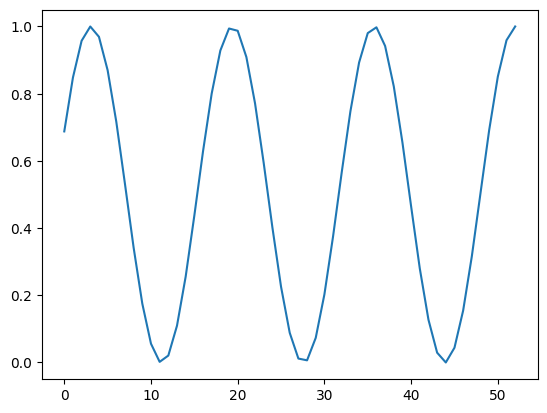

In [11]:
plt.plot(timeseries_train)

stab
['+YZZYXZ', '+IIYXXZ'] ['+ZXIXYY', '-ZXIXZZ']


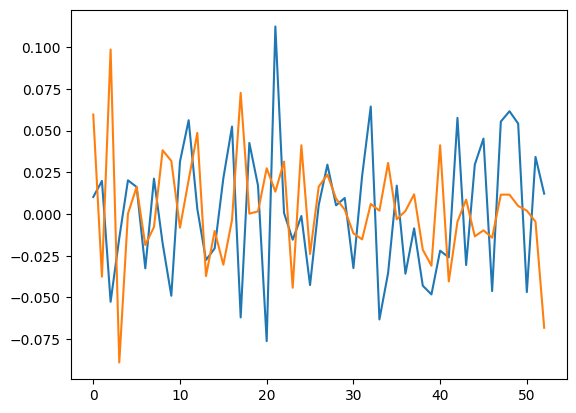

Step 0
stab
['-IXIXXZ', '+ZYZZII'] ['-IXXIXY', '-YYZIYZ']


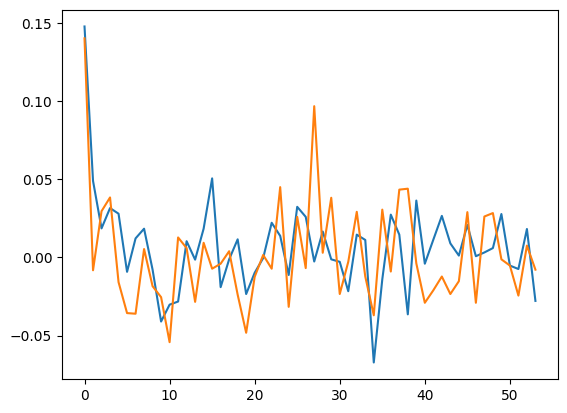

0.5009916926998391


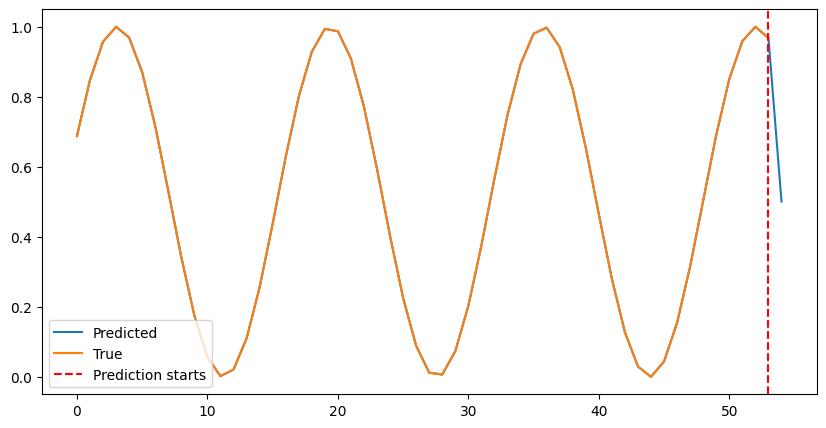

Step 1
stab
['+XYXYXX', '-XIYIXY'] ['-XZZYYI', '-IIYZIX']


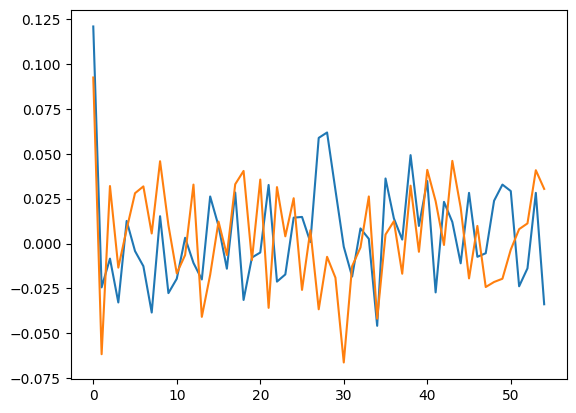

0.5788443240342465


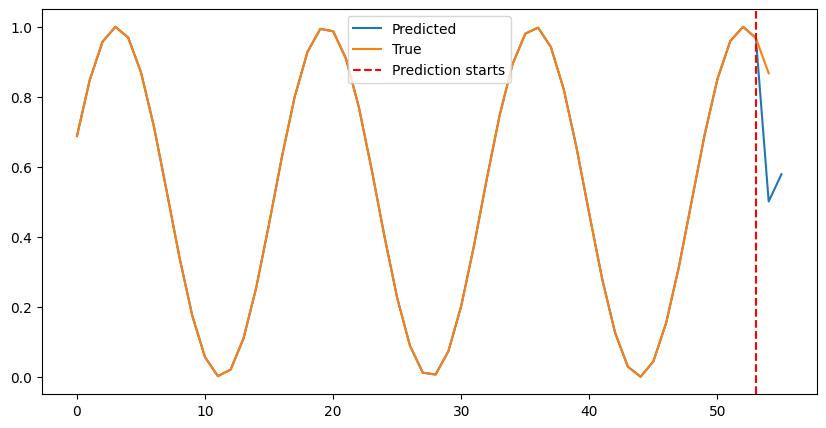

Step 2
stab
['+ZZIXZX', '+IXZXYX'] ['+YZIZZY', '+YXYIXY']


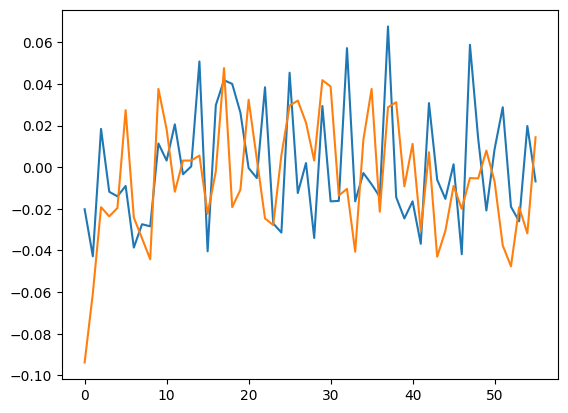

0.5450570564004522


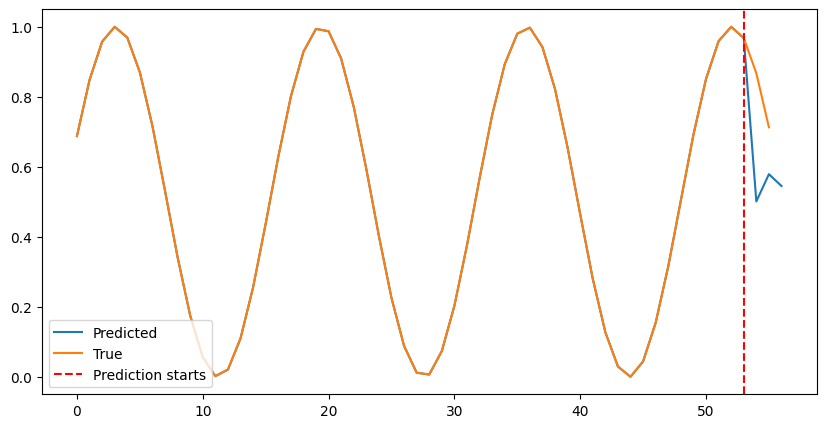

Step 3
stab
['+IYYXZX', '+ZYXZXZ'] ['-ZZXXIZ', '-YYYZYI']


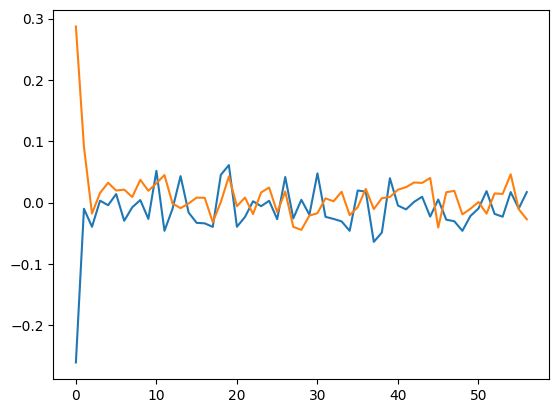

0.45903783122271585


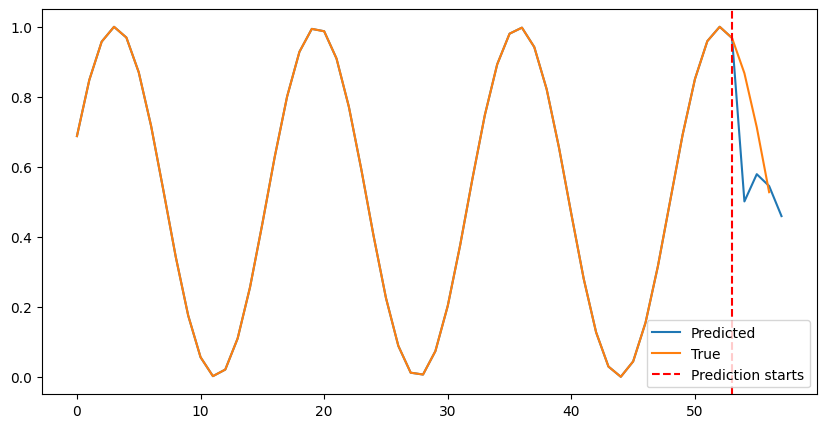

Step 4
stab
['-YYYIZZ', '-XZZZXZ'] ['+ZYZYYZ', '-YZYXZX']


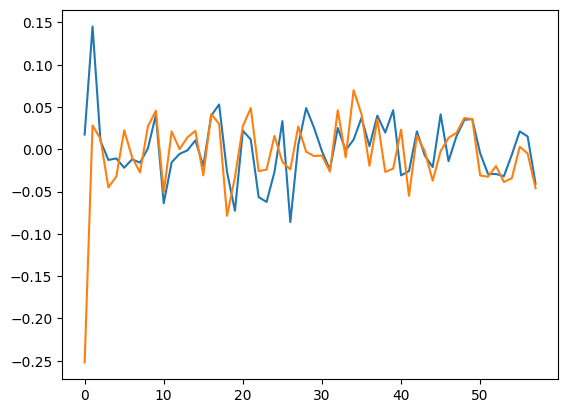

0.4240537491171402


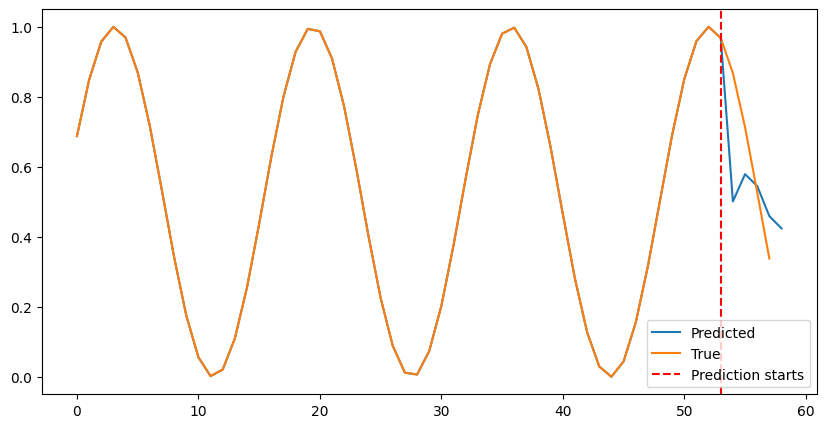

Step 5
stab
['-IIIXYX', '+IIYYYY'] ['-IZYXXI', '+IZZZIZ']


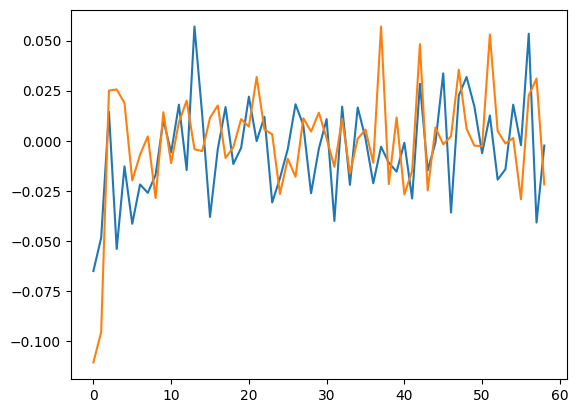

0.47134238242767534


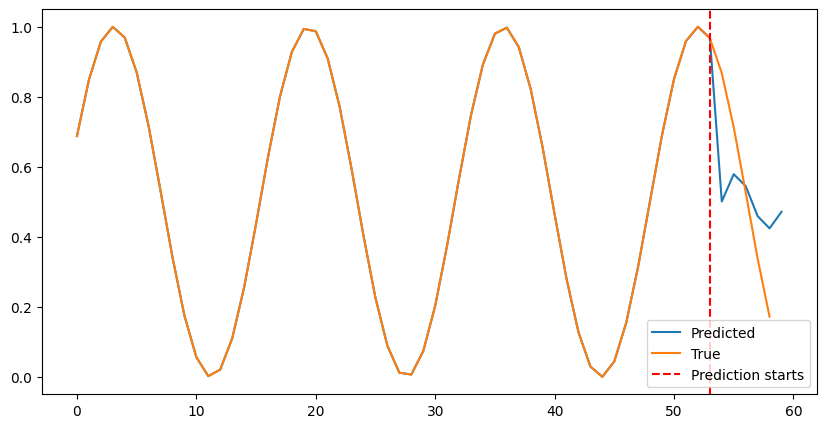

In [12]:
backend = AerSimulator()
num_tot_obs=len(generate_ZI_pauli_strings(num_measurement))
X_train=[]
for reservoir_circuit in reservoirs:
    circuit = quantum_part_circuit(timeseries_train, num_qubits, num_measurement, reservoir_circuit,type='quantum_stab')
    circuit = transpile(circuit, backend)
    counts_train = execute_reservoir(timeseries_train,num_measurement,shots, circuit)
    obs_train = compute_expectations_for_all_timesteps(counts_train, generate_ZI_pauli_strings(num_measurement)[1:num_tot_obs-1])
    X_train.append(obs_train)  # shape (train-1, num_measurement)
for obs in X_train:
    plt.plot(obs)
plt.show()
# Build supervised learning dataset with memory k
X_train_k = []
y_train_k = []
for i in range(0, len(y_train)):
    # Build feature vector stacking k past observations
    Xi = []
    Yi = []
    for j in range(k):
        for r in range(0,num_reservoirs):
            Xi.extend(X_train[r][i-j-1])  # notice: i-j-1 because X_train is already delayed by 1
        Yi.append(y_train_aux[i-j-1])
    X_train_k.append(Xi[::-1])
    y_train_k.append(Yi[::-1])

# Convert to numpy arrays
X_train_k=np.array(X_train_k)
y_train_k = np.array(y_train_k)

# Train Ridge regression

model.fit(X_train_k[warmup+k:], y_train_k[warmup+k:])

# Prediction function
def predict_one_step_ahead(model, timeseries_aux, num_qubits, num_measurement, reservoirs, shots=shots):
    ts_list = timeseries_aux.flatten().tolist()
    obs=[]
    for reservoir_circuit in reservoirs:
        circuit = quantum_part_circuit(ts_list, num_qubits, num_measurement, reservoir_circuit,type='quantum_stab')
        circuit = transpile(circuit, backend)
        counts = execute_reservoir(ts_list,num_measurement,shots, circuit)
        obs.append(compute_expectations_for_all_timesteps(counts, generate_ZI_pauli_strings(num_measurement)[1:num_tot_obs-1]))
    for ob in obs:
        plt.plot(ob)
    plt.show()
    #plt.plot(obs)
    #plt.show()
    # Append newest observable
    # Build feature vector with k lags
    Xi = []
    for j in range(k):
        for r in range (0, num_reservoirs):
            Xi.extend(obs[r][len(obs[0])-j-1])  # take last k observations
    
    Xi = np.array(Xi[::-1]).reshape(1,-1)
    y_pred = model.predict(Xi)
    if k==1:
        return y_pred[-1]
    else:
        return y_pred[-1][-1]

# Now autoregressive prediction
timeseries_aux = np.vstack([np.array(timeseries_train.copy()).reshape(-1, 1), y_train[-1].reshape(1,1)])
y_pred = timeseries_aux.copy()


for i in range(len(timeseries_pred)):
    print(f"Step {i}")
    
    pred_step = predict_one_step_ahead(model, timeseries_aux, num_qubits, num_measurement, reservoirs, shots=shots)
    print(pred_step)
    timeseries_aux = np.vstack([timeseries_aux, np.array([[pred_step]])])
    
    plt.figure(figsize=(10, 5))
    plt.plot(timeseries_aux, label='Predicted')
    plt.plot(timeseries[:i+train], label='True')
    plt.axvline(x=train-1, color='red', linestyle='--', label='Prediction starts')
    plt.legend()
    plt.show()


(52.0, 59.0)

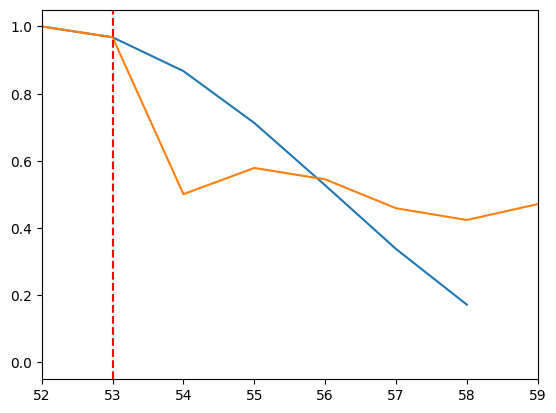

In [13]:
plt.plot(timeseries)
plt.plot(timeseries_aux)
plt.axvline(x=train-1, color='red', linestyle='--', label='Prediction starts')
plt.xlim(train-2,len(timeseries))